# **Logistic Regression v/s Random Forest v/s XGBClassification**

#### **Importing necessary libraries** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score

#### **Dataset Loading**

In [9]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.DataFrame(data.target)

print(f"Dataset size - {X.shape}")
print(f"Target Distribution - ")
print(y.value_counts())

Dataset size - (569, 30)
Target Distribution - 
0
1    357
0    212
Name: count, dtype: int64


#### **Split data into training and testing sets**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Standard Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### **Model 1: Logistic Regression (L1 & L2 Regularization)**

In [17]:
# L2 - Ridge - Default 
logreg_l2 = LogisticRegression(penalty = 'l2', 
                               C = 1.0,
                               solver = 'liblinear',
                               random_state = 42
                              )

logreg_l2.fit(X_train_scaled, y_train.values.ravel())
y_pred_l2 = logreg_l2.predict(X_test_scaled)

print("L2 Regularization : ")
print(f"Test Accuracy - {accuracy_score(y_test, y_pred_l2)*100:.4f} %")

L2 Regularization : 
Test Accuracy - 98.6014 %


In [24]:
# L1 - Lasso 
logreg_l1 = LogisticRegression(
    penalty = 'l1',
    random_state = 42,
    C = 1,
    solver = 'liblinear'
)

logreg_l1.fit(X_train_scaled, y_train.values.ravel())
y_pred_l1 = logreg_l1.predict(X_test_scaled)

print("L1 Regularization")
print(f"Test Accuracy - {accuracy_score(y_test, y_pred_l1)*100:.4f} %")

L1 Regularization
Test Accuracy - 99.3007 %


#### **Model 2: Random Forest Classifier**

In [51]:
rf_model = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 10,
    random_state = 42
)

rf_model.fit(X_train, y_train.values.ravel())
y_pred_rf = rf_model.predict(X_test)

print(f"Test Accuracy (RF): {accuracy_score(y_test, y_pred_rf)*100:.4f} %")
print(f"\nFeature Importance (Top 5):")
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print(feature_importances.nlargest(5))

cv_scores = cross_val_score(rf_model, X, y.values.ravel(), cv=5, scoring='f1')
print(f"\n5-Fold CV F1 Scores: {cv_scores}")
print(f"Average CV F1 Score: {np.mean(cv_scores)*100:.4f} %")

Test Accuracy (RF): 95.8042 %

Feature Importance (Top 5):
worst area              0.149594
worst concave points    0.127289
mean concave points     0.104650
worst radius            0.086698
worst perimeter         0.080299
dtype: float64

5-Fold CV F1 Scores: [0.93617021 0.95238095 0.98611111 0.97260274 0.9787234 ]
Average CV F1 Score: 96.5198 %


#### **Model 3: XGBoost Classifier (Gradient Boosting)**

In [67]:
xgb_model = XGBClassifier(
    objective='binary:logistic',  
    n_estimators=100,             
    learning_rate=0.75,            
    max_depth=10,                  
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=32
)

xgb_model.fit(X_train, y_train.values.ravel())
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(f"Test Accuracy (XGB): {accuracy_score(y_test, y_pred_xgb)*100:.4f} %")

Test Accuracy (XGB): 97.9021 %


#### **Evaluation Metrics**

--- Comprehensive Evaluation (XGBoost) ---

Confusion Matrix:
[[50  3]
 [ 0 90]]


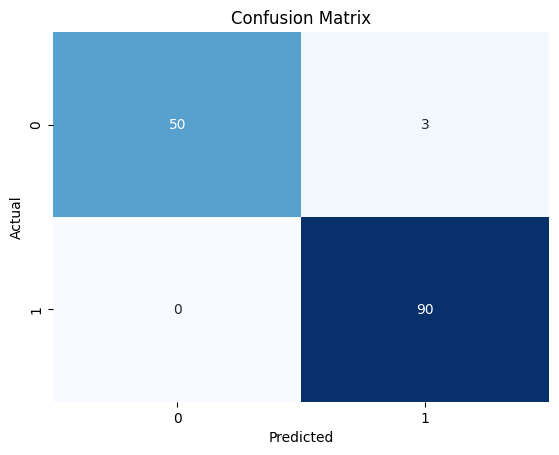


Classification Report (XGBoost):
              precision    recall  f1-score   support

   malignant       1.00      0.94      0.97        53
      benign       0.97      1.00      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.97      0.98       143
weighted avg       0.98      0.98      0.98       143

ROC-AUC Score: 0.9948


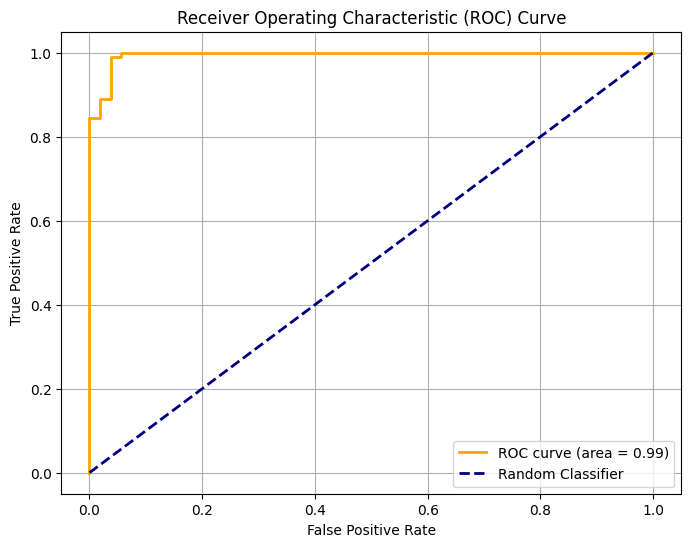

In [68]:
### CELL 5: Comprehensive Evaluation of XGBoost Model ###
print("--- Comprehensive Evaluation (XGBoost) ---")

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix:")
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=data.target_names))

# 3. ROC-AUC Score and Curve
auc_score = roc_auc_score(y_test, y_proba_xgb)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)

print(f"ROC-AUC Score: {auc_score:.4f}")

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()